In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Reading The Raw Data

In [2]:
df = pd.read_csv("movies_metadata.csv", low_memory=False)
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


# Exploring the Data
Graph showing the top 10 languages for movies excluding english. English would dominate the graph.

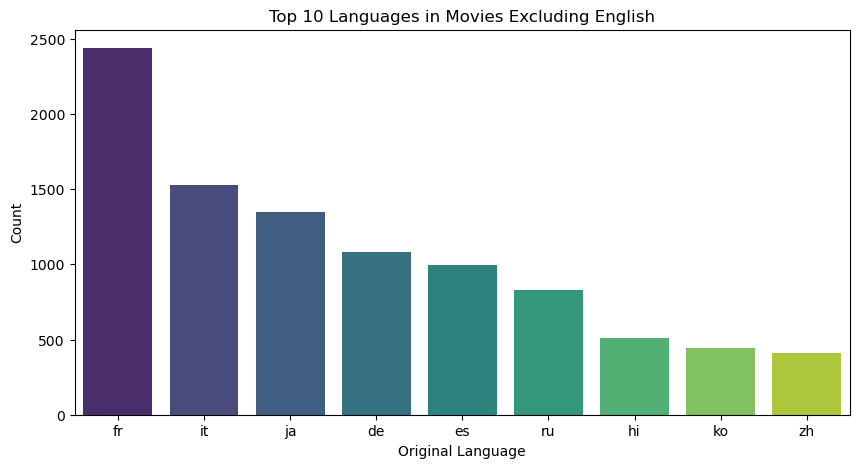

In [3]:
#Top 10 languages exlucding English
language_counts = df['original_language'].value_counts()
top_10_languages = language_counts.head(10)
top_10_languages = top_10_languages.iloc[1:]

plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_languages.index, y=top_10_languages.values, palette='viridis')
plt.title('Top 10 Languages in Movies Excluding English')
plt.xlabel('Original Language')
plt.ylabel('Count')
plt.show()

# Top 10 Movies In The Dataset
Below are the top 10 movies in the data caclulated from vote average and vote count.

In [4]:
df[df['vote_count'] > 2000][['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending=False).head(10)

,title,vote_average,vote_count
314,The Shawshank Redemption,8.5,8358.0
834,The Godfather,8.5,6024.0
2211,Life Is Beautiful,8.3,3643.0
5481,Spirited Away,8.3,3968.0
1152,One Flew Over the Cuckoo's Nest,8.3,3001.0
1176,Psycho,8.3,2405.0
2843,Fight Club,8.3,9678.0
1178,The Godfather: Part II,8.3,3418.0
12481,The Dark Knight,8.3,12269.0
292,Pulp Fiction,8.3,8670.0


# Data Wrangling
Null values must be removed.

In [5]:
df_kmeans = pd.read_csv("movies_metadata_kmeans.csv", low_memory=False)
df_kmeans = df_kmeans[['budget','popularity','revenue','runtime','vote_average','vote_count', 'title']]
df_kmeans.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,title
0,30000000,21.946943,373554033.0,81.0,7.7,5415.0,Toy Story
1,65000000,17.015539,262797249.0,104.0,6.9,2413.0,Jumanji
2,0,11.7129,0.0,101.0,6.5,92.0,Grumpier Old Men
3,16000000,3.859495,81452156.0,127.0,6.1,34.0,Waiting to Exhale
4,0,8.387519,76578911.0,106.0,5.7,173.0,Father of the Bride Part II


In [6]:
df_kmeans.isnull().sum() #Checking for null values

budget            0
popularity        5
revenue           6
runtime         263
vote_average      6
vote_count        6
title             6
dtype: int64

In [7]:
df_kmeans.dropna(inplace=True)
df_kmeans.isnull().sum() #Checking for null values

budget          0
popularity      0
revenue         0
runtime         0
vote_average    0
vote_count      0
title           0
dtype: int64

In [8]:
df_kmeans['vote_count'].describe()

count    45203.000000
mean       110.506515
std        492.638190
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

In [9]:
df_kmeans = df_kmeans[df_kmeans['vote_count']>30]
df_kmeans['vote_count'].describe()

count    12178.000000
mean       388.336591
std        891.671853
min         31.000000
25%         50.000000
50%         99.000000
75%        299.000000
max      14075.000000
Name: vote_count, dtype: float64

# Scaling The Data
The data is scaled for the K-Means algorithm.

In [10]:
minmax_processed = preprocessing.MinMaxScaler().fit_transform(df_kmeans.drop('title',axis=1))
df_kmeans_scaled = pd.DataFrame(minmax_processed, index=df_kmeans.index, columns=df_kmeans.columns[:-1])
df_kmeans_scaled.head()

,budget,popularity,revenue,runtime,vote_average,vote_count
0,0.078947,0.040082,0.133988,0.092360,0.810526,0.383367
1,0.171053,0.031075,0.094261,0.118586,0.726316,0.169610
2,0.000000,0.021389,0.000000,0.115165,0.684211,0.004343
3,0.042105,0.007045,0.029216,0.144812,0.642105,0.000214
4,0.000000,0.015315,0.027468,0.120867,0.600000,0.010111


# Finding The Correct Number of Clusters
A function is created for the elbow method.

In [11]:
#Creating the function to find the optimal number of clusters using the elbow method
def k_means_optimization(data, max_k):
    means=[]
    inertias=[]
    
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, n_init='auto')
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    fig = plt.subplots(figsize=(10,5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

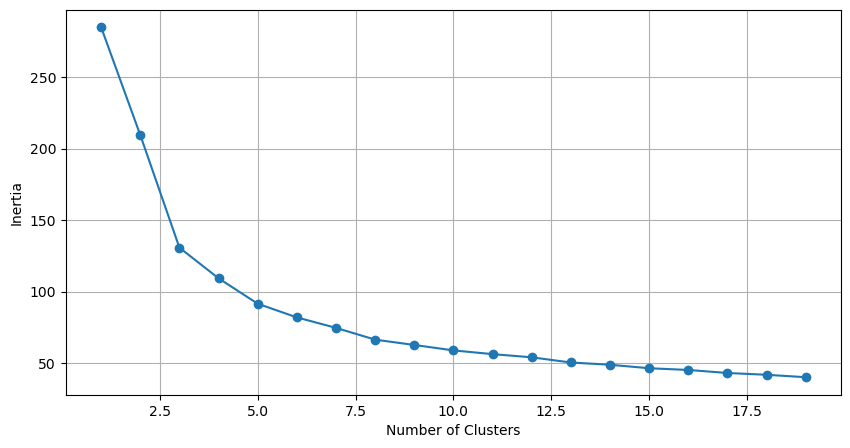

In [12]:
k_means_optimization(df_kmeans_scaled, 20)

# Cluster Predictions Are Inserted Into Data

In [13]:
kmeans = KMeans(n_clusters=5, n_init='auto')
kmeans.fit(df_kmeans_scaled)
df_kmeans_scaled['cluster'] = kmeans.labels_
df_kmeans['cluster'] = kmeans.labels_
df_kmeans.head(20)

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster
0,30000000,21.946943,373554033.0,81.0,7.7,5415.0,Toy Story,3
1,65000000,17.015539,262797249.0,104.0,6.9,2413.0,Jumanji,0
2,0,11.7129,0.0,101.0,6.5,92.0,Grumpier Old Men,4
3,16000000,3.859495,81452156.0,127.0,6.1,34.0,Waiting to Exhale,4
4,0,8.387519,76578911.0,106.0,5.7,173.0,Father of the Bride Part II,4
5,60000000,17.924927,187436818.0,170.0,7.7,1886.0,Heat,0
6,58000000,6.677277,0.0,127.0,6.2,141.0,Sabrina,0
7,0,2.561161,0.0,97.0,5.4,45.0,Tom and Huck,1
8,35000000,5.23158,64350171.0,106.0,5.5,174.0,Sudden Death,4
9,58000000,14.686036,352194034.0,130.0,6.6,1194.0,GoldenEye,0


# Cluster Distribution
Below are several graphs showing the distribution of clusters.

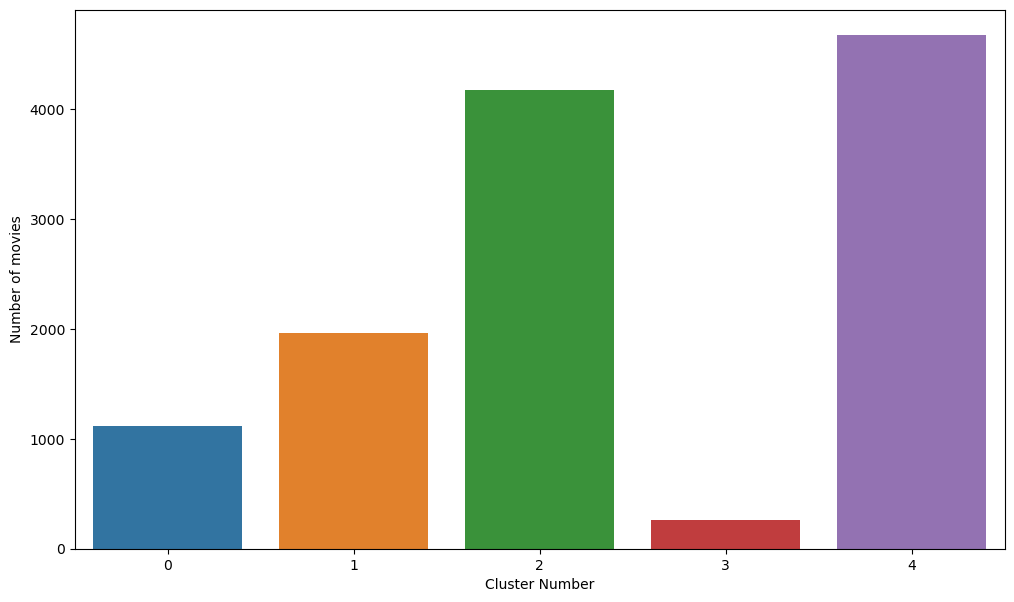

In [14]:
plt.figure(figsize=(12,7))
axis = sns.barplot(x=np.arange(0,5,1),y=df_kmeans.groupby(['cluster']).count()['budget'].values)
x=axis.set_xlabel("Cluster Number")
x=axis.set_ylabel("Number of movies")

<Axes: xlabel='budget', ylabel='vote_average'>

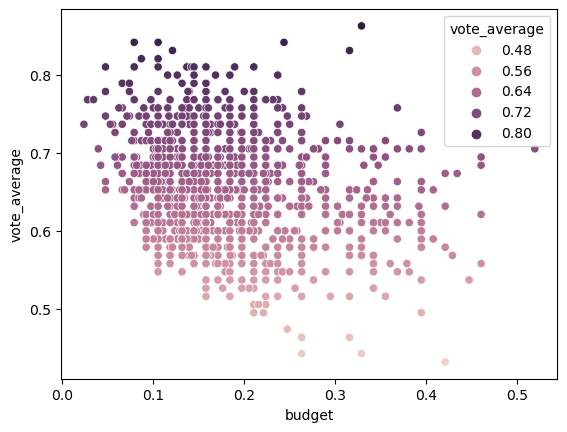

In [15]:
sns.scatterplot(df_kmeans_scaled[df_kmeans_scaled['cluster'] == 0], x="budget", y="vote_average", hue='vote_average')

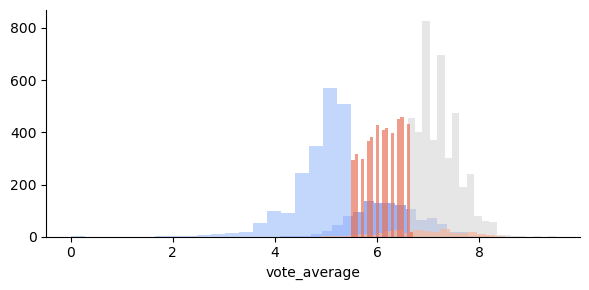

In [16]:
g = sns.FacetGrid(df_kmeans,hue='cluster',palette='coolwarm',aspect=2)
g = g.map(plt.hist,'vote_average',bins=20,alpha=0.7)

# Cluster Size
We see a sample of the cluster with the highest rated movies.

In [17]:
size_array = list(df_kmeans.groupby(['cluster']).count()['budget'].values)
size_array

[1116, 1966, 4168, 260, 4668]

In [18]:
df_kmeans[df_kmeans['cluster']==size_array.index(sorted(size_array)[0])].sample(5)

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster
10979,120000000,18.907948,4.619831e+08,117.0,6.6,3991.0,Cars,3
11925,150000000,5.587707,7.097098e+08,144.0,6.6,4113.0,Transformers,3
30556,165000000,16.993841,3.896819e+08,120.0,4.9,2550.0,Independence Day: Resurgence,3
30700,74000000,547.488298,1.156731e+09,91.0,6.4,4729.0,Minions,3
30315,175000000,23.985587,8.576112e+08,94.0,7.9,6737.0,Inside Out,3


# Merging Clusters Into Data
A new view of the data is created for the recommendation system.

In [19]:
merged_df = df.merge(df_kmeans, on='title', how='left')
merged_df = merged_df[['title','overview','genres','cluster']]
merged_df.dropna(inplace=True)

In [20]:
merged_df.head(10)

,title,overview,genres,cluster
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",3.0
1,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0.0
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",4.0
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",4.0
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",4.0
5,Heat,"Obsessive master thief, Neil McCauley leads a ...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",0.0
6,Sabrina,An ugly duckling having undergone a remarkable...,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",0.0
7,Sabrina,An ugly duckling having undergone a remarkable...,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",2.0
8,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",1.0
9,Sudden Death,International action superstar Jean Claude Van...,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",4.0


# TF-IDF Vectorizer
TF-IDF is used to turn the descriptions of movies into a matrix.
Similarty is also calculated.

In [21]:
# Create a TfidfVectorizer with English stopwords
tfidf = TfidfVectorizer(stop_words='english',lowercase=True)

# Construct the TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(merged_df['overview'])
tfidf_matrix.shape

(14890, 36534)

In [22]:
# Cosine Similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
#Setting index
merged_df = merged_df.reset_index()
titles = merged_df['title']
indices = pd.Series(merged_df.index, index=merged_df['title'])

# Recommendation
This is the simple recommendation system using the similarity scores provided by cosine similarty.

In [23]:
def get_recommendations(title):
    idx = indices[title]
    similarity_score = list(enumerate(cosine_sim[idx]))
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    similarity_score = similarity_score[1:31]
    movie_indices = [i[0] for i in similarity_score]
    return titles.iloc[movie_indices]

# Replace 'The Godfather' With Example Inputs
Another movie may also be chosen, but it must be part of the data set.  
  Examples: Jumanji, Ace Ventura: When Nature Calls

In [24]:
get_recommendations('The Godfather').head(10)

780       The Godfather: Part II
1308     The Godfather: Part III
10665                 Blood Ties
6214                    Election
6215                    Election
4250                    Mobsters
12678             Bad Turn Worse
14277              Live by Night
3054             Family Business
9052                   Miss Bala
Name: title, dtype: object

# Sample Input
Sample input can be generated by running the cell below.

In [25]:
merged_df.sample(n=10)

,index,title,overview,genres,cluster
10441,23334,The Secret,"Husband, wife, and daughter have moved from Bo...","[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",4.0
1938,2931,Alice Sweet Alice,Alice is a withdrawn 12-year-old who lives wit...,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",4.0
13254,36045,Antigang,A french police unit that try to stop a group ...,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",4.0
11850,28940,Miss Julie,Over the course of a midsummer night in Ferman...,"[{'id': 18, 'name': 'Drama'}]",4.0
14680,45198,The One,During WWII a Soviet artillery unit is fightin...,"[{'id': 10752, 'name': 'War'}, {'id': 18, 'nam...",0.0
13031,34682,Home,Big home of Shamanov family has everything - e...,"[{'id': 18, 'name': 'Drama'}]",0.0
2274,3480,Who's That Girl,An uptight New York tax lawyer gets his life t...,"[{'id': 35, 'name': 'Comedy'}]",1.0
5518,9767,61*,"In 1961, Roger Maris and Mickey Mantle played ...","[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",4.0
6453,11897,Employee of the Month,When he hears that the new female employee dig...,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",1.0
5154,8881,Heaven Can Wait,Henry Van Cleve presents himself at the gates ...,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",2.0
